In [56]:
import numpy as np
import random
import gym
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import time


In [57]:
env = gym.make("Taxi-v3")
state_size = env.observation_space.n
action_size = env.action_space.n


In [58]:
print(state_size, action_size)

500 6


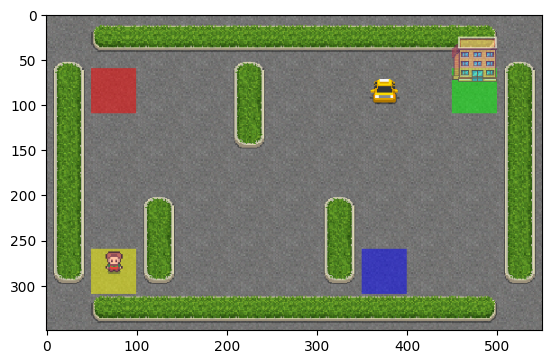

In [59]:

env.reset()
fig,ax=plt.subplots()
ax.imshow(env.render(mode='rgb_array'))
plt.show()

In [66]:
def build_model(state_size, action_size):
    model = Sequential()
    model.add(Dense(24, input_dim=state_size, activation='relu'))  # Input layer with 500 features
    model.add(Dense(24, activation='relu'))  # Hidden layer
    model.add(Dense(action_size, activation='linear'))  # Output layer
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.1))  # Compile the model
    return model

# Create the model
model = build_model(state_size=500, action_size=env.action_space.n)

In [61]:
import random

class ReplayBuffer:
    def __init__(self, max_size=1000):
        self.buffer = []
        self.max_size = max_size

    def store(self, experience):
        if len(self.buffer) >= self.max_size:
            self.buffer.pop(0)
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

replay_buffer = ReplayBuffer()


In [62]:
def one_hot_encode(state, state_size):
    one_hot = np.zeros(state_size)
    one_hot[state] = 1
    return np.reshape(one_hot, [1, state_size])  # Reshape to (1, state_size)


In [63]:
def train_dqn(episodes, batch_size):
    gamma = 0.95  # Discount rate
    epsilon = 1.0  # Exploration rate
    epsilon_min = 0.01
    epsilon_decay = 0.995

    for episode in range(episodes):
        state = env.reset()
        state = one_hot_encode(state, 500)  # One-hot encode the state
        done = False
        total_reward = 0

        while not done:
            if np.random.rand() <= epsilon:
                action = random.choice(range(env.action_space.n))  # Exploration
            else:
                action = np.argmax(model.predict(state))  # Exploitation (Q-network prediction)

            next_state, reward, done, _ = env.step(action)
            next_state = one_hot_encode(next_state, 500)  # One-hot encode the next state

            replay_buffer.store((state, action, reward, next_state, done))  # Store the experience
            state = next_state  # Update the current state
            total_reward += reward

            if done:
                print(f"Episode: {episode + 1}, Total reward: {total_reward}, Epsilon: {epsilon}")
                break

            # Train the model using the replay buffer
            if len(replay_buffer.buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                train_batch(batch, gamma)

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay  # Reduce exploration over time


In [64]:
def train_batch(batch, gamma):
    for state, action, reward, next_state, done in batch:
        target = reward
        if not done:
            target += gamma * np.amax(model.predict(next_state))  # Predict the Q-values for the next state

        target_f = model.predict(state)  # Predict the Q-values for the current state
        target_f[0][action] = target  # Update the Q-value for the action taken

        model.fit(state, target_f, epochs=1, verbose=0)  # Train the model with the updated target


In [67]:
train_dqn(5, 16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [68]:
def test_agent(episodes=5):
    for episode in range(episodes):
        state = env.reset()
        state = one_hot_encode(state, 500)  # One-hot encode the initial state
        done = False
        total_reward = 0

        print(f"\nStarting Episode {episode + 1}")
        while not done:
            # Render the environment and display it using matplotlib
            fig, ax = plt.subplots()
            ax.imshow(env.render(mode='rgb_array'))
            plt.axis('off')  # Hide axes
            plt.show()

            # Choose action using the trained model
            action = np.argmax(model.predict(state))
            next_state, reward, done, _ = env.step(action)
            next_state = one_hot_encode(next_state, 500)  # One-hot encode the next state
            total_reward += reward

            # Update the state
            state = next_state

            # Optional: Pause to visualize the rendering for a short duration
            time.sleep(0.5)

            if done:
                print(f"Episode {episode + 1} finished with total reward: {total_reward}")
                break



Starting Episode 1


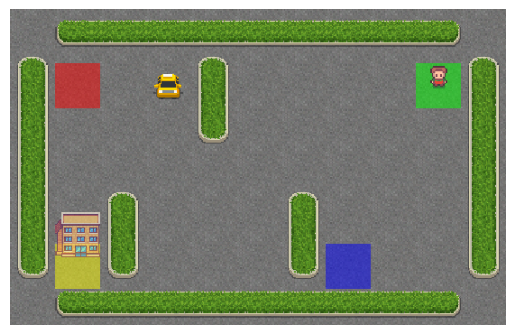

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


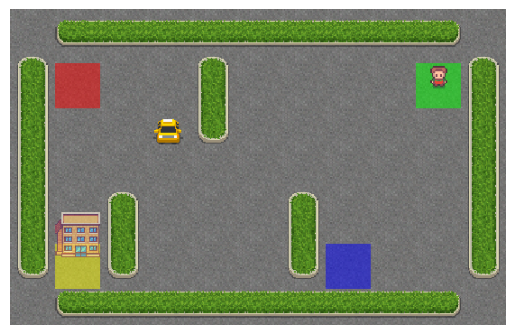

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


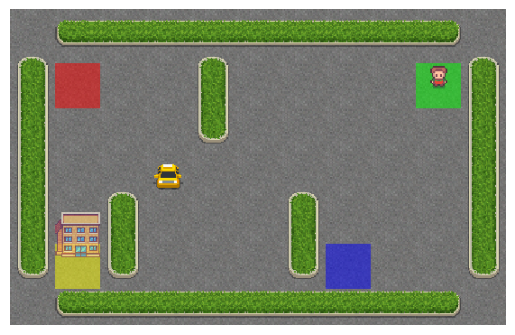

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


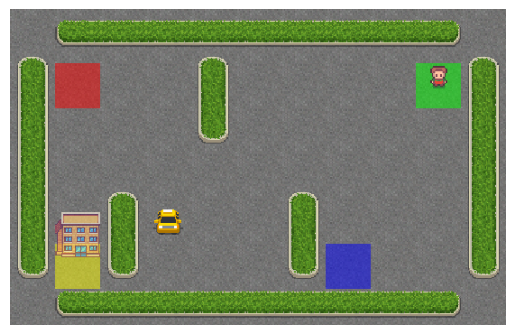

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


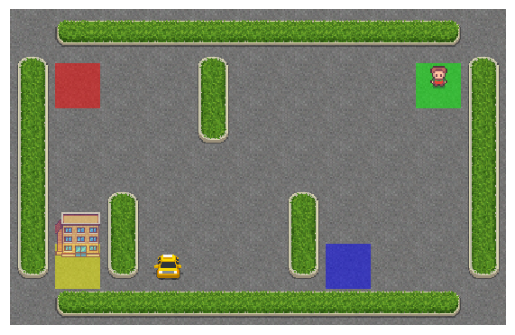

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


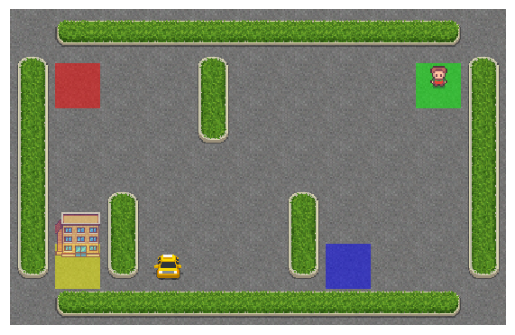

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


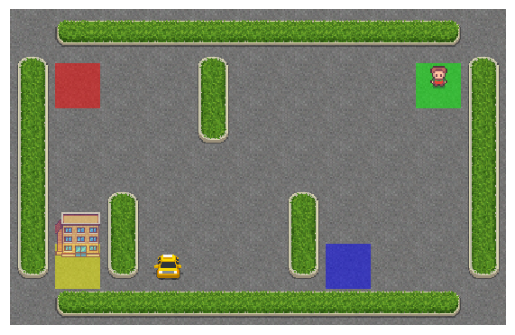

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


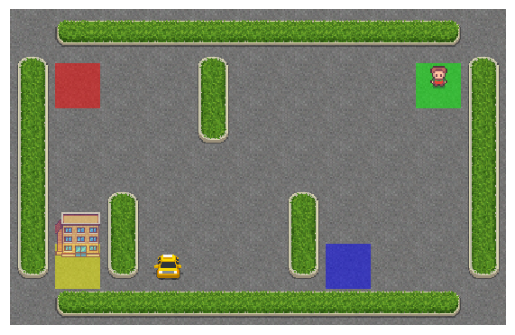

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


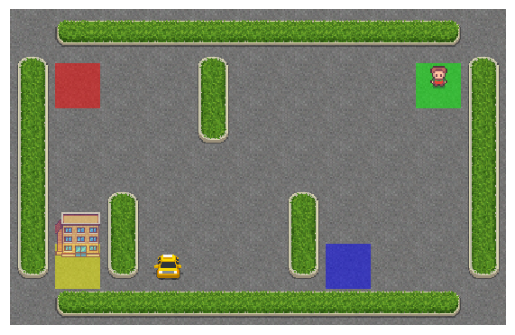

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


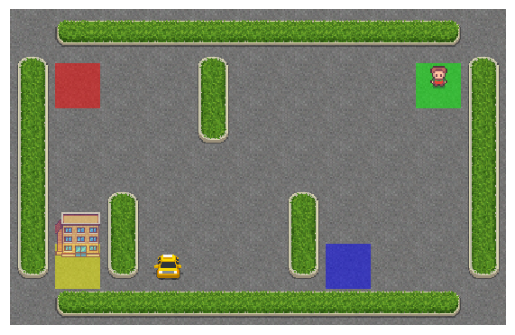

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


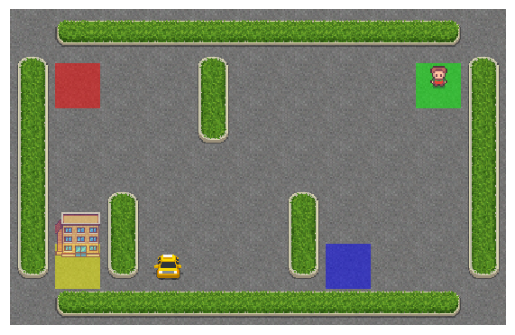

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


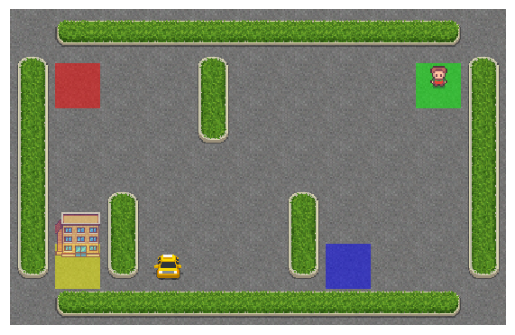

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


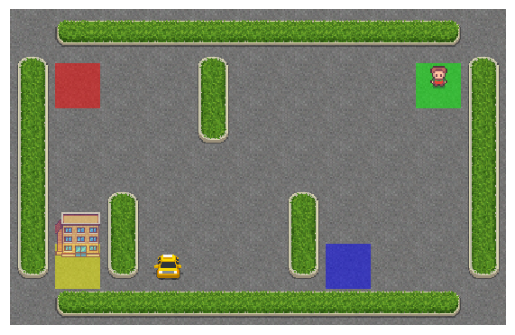

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


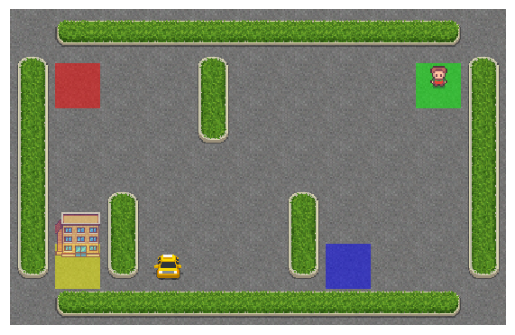

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


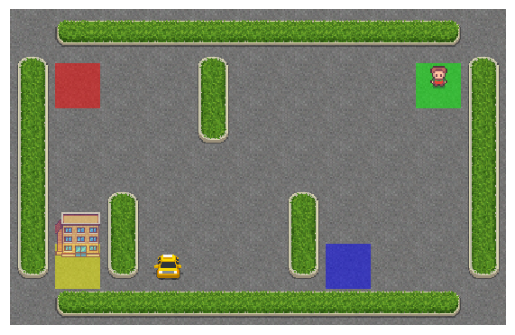

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


KeyboardInterrupt: 

In [72]:
# Assuming the model has been trained using train_dqn
test_agent(episodes=1)  # Test for 5 episodes and visualize the environment
